In [17]:
# import torch
from models import *
from utils import get_bu_tensor
from prepro_labels import *
from opts import opts
import random
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
import pickle

SOS_token = 0
EOS_token = 1
opt = opts

In [18]:
def evaluate(lang, encoder1, encoder2, decoder, vis_tensor, sent1, sent2=None):
    # max_length = opt.MAX_LENGTH
    with torch.no_grad():
        input1_tensor, input2_tensor = tensorFromSentence(lang, sent1, sent2)
        input1_length = input1_tensor.size(0)  # [0]
        input2_length = input2_tensor.size(0)
        # no_boxes = vis_tensor.size(0)

        encoder1_hidden = encoder1.initHidden()
        encoder2_hidden = encoder2.initHidden()

        encoder1_outputs = torch.zeros(int(opt.MAX_LENGTH / 2), encoder1.hidden_size, device=opt.device)
        encoder2_outputs = torch.zeros(int(opt.MAX_LENGTH / 2), encoder2.hidden_size, device=opt.device)
#         print(encoder1_outputs.size())
#         print(encoder2_outputs.size())
        
        for ei in range(input1_length):
            encoder1_output, encoder1_hidden = encoder1(
                input1_tensor[ei], encoder1_hidden)
            if ei < opt.MAX_LENGTH / 2:
                encoder1_outputs[ei] += encoder1_output[0, 0]

        for ei in range(input2_length):
            encoder2_output, encoder2_hidden = encoder2(
                input2_tensor[ei], encoder2_hidden)
            if ei < opt.MAX_LENGTH / 2:
                encoder2_outputs[ei] = encoder2_output[0, 0]

        encoder_outputs = torch.cat((encoder1_outputs, encoder2_outputs), 0)
        decoder_input = torch.tensor([[SOS_token]], device=opt.device)

        decoder_hidden = torch.cat((encoder1_hidden, encoder2_hidden), 2)

        decoded_words = []
        decoder_attentions = torch.zeros(opt.MAX_LENGTH, opt.MAX_LENGTH)
        # decoder_vis_attentions = torch.zeros(opt.MAX_LENGTH, no_boxes)

        for di in range(opt.MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, vis_tensor)
            decoder_attentions[di] = decoder_attention.data
            #             decoder_vis_attentions[di] = decoder_vis_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]  # , decoder_vis_attentions[:di+1]

In [19]:
def evaluateRandomly(lang, encoder1, encoder2, decoder, pairs, n=10):
    for i in range(n):
        #         pair = random.choice(pairs)
        index = random.choice(range(len(pairs)))
        pair = pairs[index]

        image_id = pair[3]
        print(image_id)
        vis_tensor = get_bu_tensor(opt.input_bu_folder, image_id)
        #         vis_tensor = torch.zeros(no_boxes, vis_size, device = device)

        print('>', pair[0:2])
        print('=', pair[2])
        output_words, attentions = evaluate(lang, encoder1, encoder2, decoder, vis_tensor, pair[0], pair[1])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        if i == n-1:
            plt.matshow(attentions.numpy())

In [20]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [21]:
def evaluateAndShowAttention(lang, encoder1, encoder2, attn_decoder1, input_sent1, input_sent2=None):
    output_words, attentions = evaluate(lang,
        encoder1, encoder2, attn_decoder1, input_sent1, input_sent2)
    input_sentence = input_sent1 + ' ' + input_sent2
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

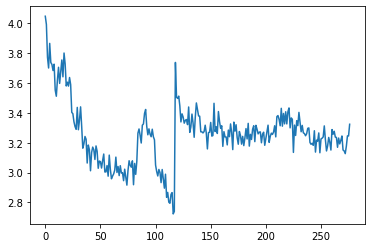

In [22]:
plot_losses = pickle.load(open('plots/plot_losses_%s'%opt.run_name, 'rb'))
plt.plot(plot_losses, '-')
plt.show()

In [23]:
Data = pickle.load(open('language.pkl', 'rb'))
# Data.keys()
lang = Data['lang']
pairs = Data['pairs']
w2v = Data['w2v'].to(device)
del Data

In [24]:
encoder1 = EncoderRNN(lang.n_words, opt.hidden_size, w2v).to(device)
encoder2 = EncoderRNN(lang.n_words, opt.hidden_size, w2v).to(device)
attn_decoder1 = AttnDecoderRNN(opt.input_size, 2*opt.hidden_size, lang.n_words, opt.vis_size, opt.no_boxes, w2v, dropout_p=0.1).to(device)

# encoder1.load_state_dict(torch.load('./models/encoder1_checkpoint.pth'))
# encoder2.load_state_dict(torch.load('./models/encoder2_checkpoint.pth'))
# attn_decoder1.load_state_dict(torch.load('./models/decoder_checkpoint.pth'))

In [25]:
# run_name = opt.run_name
# run_name = 'checkpoint'
run_name = 'v13'

print(run_name)
encoder1.load_state_dict(torch.load('./models/encoder1_%s.pth' % run_name))
encoder2.load_state_dict(torch.load('./models/encoder2_%s.pth' % run_name))
attn_decoder1.load_state_dict(torch.load('./models/decoder_%s.pth' % run_name))

v13


<All keys matched successfully>

In [26]:
from IPython.display import Image

3240
> ['top of black sneaker next to multiple linens', '']
= top of black sneaker next to multiple linens
< inside a brown surface <EOS>

9831
> ['a hand holding a orange color shining bottle', '']
= a hand holding a orange color shining bottle
< a person s lap <EOS>

16267
> ['a large pink purple and white plaid shirt', '']
= a large pink purple and white plaid shirt
< a shiny fabric <EOS>

12883
> ['an electronic machine which is fixed in a wall', '']
= an electronic machine which is fixed in a wall
< an office screen <EOS>

12791
> ['a box seem to contain some food stuff', '']
= a box seem to contain some food stuff
< a plastic wrapping <EOS>

20875
> ['an unopened package of creamy chicken and potato pie', '']
= an unopened package of creamy chicken and potato pie
< an opened k cup <EOS>

7136
> ['a package of wafer bars is laying', 'a green fabric surface']
= a package of wafer bars is laying on a green fabric surface
< a desk <EOS>

20642
> ['a picture of some rows of cards or p

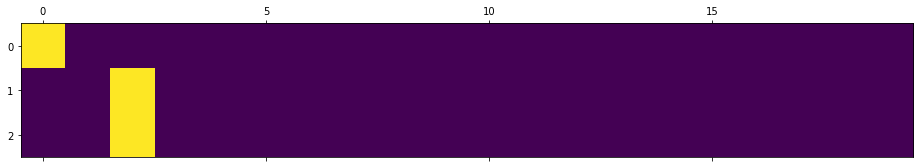

In [42]:
evaluateRandomly(lang, encoder1, encoder2, attn_decoder1, pairs)

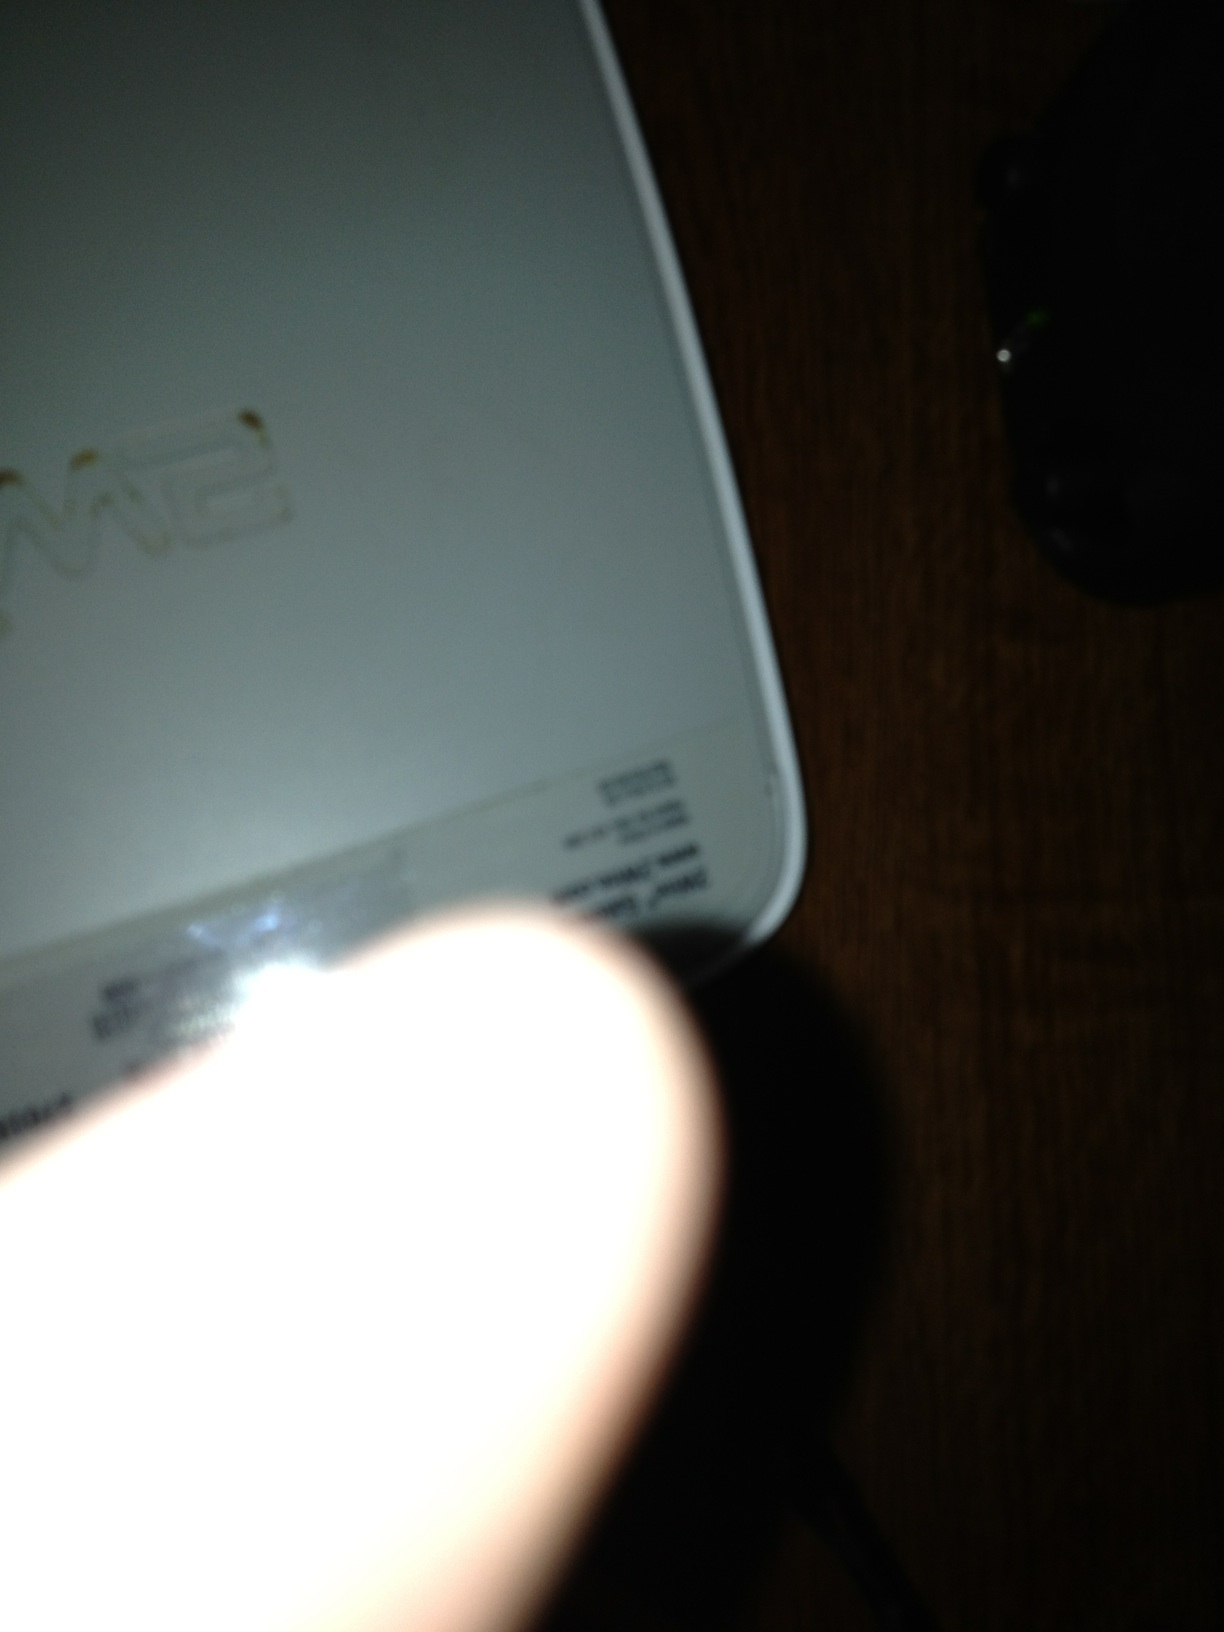

In [41]:
im_folder = '../vizwiz-caption/train/train/'
im_file = im_folder + 'VizWiz_train_00010730.jpg'
Image(im_file)

In [13]:
data = json.load(open(opt.val_file,'r'))
annotations = data['annotations']

results = []
for i, ann in enumerate(annotations):
    pair = [normalizeString(s).strip('. ') for s in ann['split']]

    image_id = ann['image_id_true']
#     print(i, image_id)
    vis_tensor = get_bu_tensor(opt.val_bu_folder, image_id)

    output_words, _ = evaluate(lang, encoder1, encoder2, attn_decoder1, vis_tensor, pair[0], pair[1])
    output_words.pop()
    output_sentence = ' '.join(output_words)
    res = {'image_id': ann['id'], 'caption': output_sentence}
    results.append(res)
    if i % 5000 == 4999:
        print('%d annotations processed.' % (i + 1))
print('Total of %d captions generated.' % (len(results)))

5000 annotations processed.
10000 annotations processed.
15000 annotations processed.
20000 annotations processed.
25000 annotations processed.
30000 annotations processed.
Total of 33145 captions generated.


In [14]:
output_file = 'results/results_%s.json' % opt.run_name
json.dump(results,open(output_file, 'w'))
print('wrote results to %s'%output_file)

wrote results to results/results_v14.json
